In [1]:
!pip install -q transformers datasets torch torchvision scikit-learn matplotlib seaborn pillow

## Импорт библиотек

In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset as HFDataset

from tqdm import tqdm

## Подключение Google Drive

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Путь к данным

In [22]:
DATA_PATH = r'/content/drive/MyDrive/ML project/CarImages/CarImages'



## Конфигурация модели

In [34]:
CONFIG = {
    'img_size': 224,
    'batch_size': 32,
    'epochs': 30,
    'learning_rate_head': 5e-5, # Learning rate for the classification head
    'learning_rate_finetune': 2e-5, # Learning rate for fine-tuning the whole model
    'train_split': 0.7,
    'val_split': 0.15,
    'test_split': 0.15,
    'random_seed': 42,
    'classes': ['toyota', 'porsche', 'bentley', 'bmw',  'audi' ],
    'model_name': 'google/vit-base-patch16-224',
    'num_labels': 5,
    'warmup_steps': 500,
    'weight_decay': 0.01, # <-- ВОЗВРАЩАЕМ к стандартному значению
}


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Установка случайного зерна

In [24]:
np.random.seed(CONFIG['random_seed'])
torch.manual_seed(CONFIG['random_seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['random_seed'])

## Функция анализа датасета

In [25]:
def analyze_dataset(data_path):
    class_counts = {}
    total_images = 0

    for class_name in CONFIG['classes']:
        class_path = os.path.join(data_path, class_name)
        if os.path.exists(class_path):
            count = len([f for f in os.listdir(class_path)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = count
            total_images += count
            print(f"{class_name:10} : {count:5} изображений")

    print(f"{'ВСЕГО':10} : {total_images:5} изображений")
    return class_counts

class_distribution = analyze_dataset(DATA_PATH)

toyota     :   552 изображений
porsche    :   471 изображений
bentley    :   564 изображений
bmw        :   480 изображений
audi       :   556 изображений
ВСЕГО      :  2623 изображений


In [26]:
print("CONFIG classes:")
for c in CONFIG['classes']:
    print(f"'{c}'")

print("\nFolders in DATA_PATH:")
for f in os.listdir(DATA_PATH):
    print(f"'{f}'")


CONFIG classes:
'toyota'
'porsche'
'bentley'
'bmw'
'audi'

Folders in DATA_PATH:
'bentley'
'bmw'
'audi'
'porsche'
'toyota'


## Создание датасета PyTorch

In [40]:
class CarDataset(Dataset):
    def __init__(self, image_paths, labels, feature_extractor, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.augment = augment

        # Аугментации для training (без ToTensor и Normalize, это делает feature_extractor)
        # Temporarily disable all torchvision augmentations to isolate the error
        self.train_transforms = transforms.Compose([])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Загрузка изображений
        image = Image.open(self.image_paths[idx]).convert('RGB')

        # Аугментация для train
        if self.augment:
            # Apply augmentations only if self.train_transforms is not empty
            if len(self.train_transforms.transforms) > 0:
                image = self.train_transforms(image)

        # feature_extractor теперь принимает PIL Image и сам делает ToTensor и Normalize
        encoding = self.feature_extractor(image, return_tensors='pt')
        pixel_values = encoding['pixel_values'].squeeze()

        return {
            'pixel_values': pixel_values,
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

## Загрузка и разделение данных

In [28]:
def load_and_split_data(data_path):
    all_images = []
    all_labels = []

    class_to_idx = {class_name: idx for idx, class_name in enumerate(CONFIG['classes'])}

    for class_name in CONFIG['classes']:
        class_path = os.path.join(data_path, class_name)
        if os.path.exists(class_path):
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_name)
                    all_images.append(img_path)
                    all_labels.append(class_to_idx[class_name])

    # Add a check for empty dataset before splitting
    if not all_images:
        print(f"\nError: No images found at {data_path}. Please check the DATA_PATH and directory structure.")
        # Return empty lists or raise an error to prevent the ValueError in train_test_split
        return ([], []), ([], []), ([], []) # Return empty datasets to avoid further errors

    # Разделение на train и val+test
    train_images, temp_images, train_labels, temp_labels = train_test_split(
        all_images, all_labels,
        test_size=CONFIG['val_split'] + CONFIG['test_split'],
        random_state=CONFIG['random_seed'],
        stratify=all_labels
    )

    # Разделение temp на val и test
    val_images, test_images, val_labels, test_labels = train_test_split(
        temp_images, temp_labels,
        test_size=0.5,
        random_state=CONFIG['random_seed'],
        stratify=temp_labels
    )

    print(f"\nРазделение завершено:")
    print(f"Train: {len(train_images)} изображений")
    print(f"Val: {len(val_images)} изображений")
    print(f"Test: {len(test_images)} изображений")

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

train_data, val_data, test_data = load_and_split_data(DATA_PATH)


Разделение завершено:
Train: 1836 изображений
Val: 393 изображений
Test: 394 изображений


## Инициализация ViT Feature Extractor

In [29]:
feature_extractor = ViTFeatureExtractor.from_pretrained(CONFIG['model_name'])

## Создание DataLoaders

In [42]:
if not train_data[0]:
    print("Error: train_data is empty. Please ensure images are loaded correctly from DATA_PATH.")
    train_dataset = None
    train_loader = None
else:
    train_dataset = CarDataset(train_data[0], train_data[1], feature_extractor, augment=True)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0, pin_memory=True)

if not val_data[0]:
    print("Error: val_data is empty. Please ensure images are loaded correctly from DATA_PATH.")
    val_dataset = None
    val_loader = None
else:
    val_dataset = CarDataset(val_data[0], val_data[1], feature_extractor, augment=False)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

if not test_data[0]:
    print("Error: test_data is empty. Please ensure images are loaded correctly from DATA_PATH.")
    test_dataset = None
    test_loader = None
else:
    test_dataset = CarDataset(test_data[0], test_data[1], feature_extractor, augment=False)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

## Строим модель Vision Transformer

In [31]:
def build_vit_model():
    # Загрузка предобученной ViT
    model = ViTForImageClassification.from_pretrained(
        CONFIG['model_name'],
        num_labels=CONFIG['num_labels'],
        ignore_mismatched_sizes=True
    )

    # Заморозка базовых слоёв
    for param in model.vit.embeddings.parameters():
        param.requires_grad = False

    for param in model.vit.encoder.layer[:8].parameters():
        param.requires_grad = False

    return model

vit_model = build_vit_model()
vit_model.to(device)

# Подсчет параметров
total_params = sum(p.numel() for p in vit_model.parameters())
trainable_params = sum(p.numel() for p in vit_model.parameters() if p.requires_grad)
print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")
print(f"Замороженных параметров: {total_params - trainable_params:,}")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Всего параметров: 85,802,501
Обучаемых параметров: 28,356,869
Замороженных параметров: 57,445,632


## Функции обучения и валидации

In [32]:
def train_epoch(model, dataloader, optimizer, criterion, device, scaler=None):
    """Обучение на одной эпохе"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for batch in pbar:
        pixel_values = batch['pixel_values'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        optimizer.zero_grad()

        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': running_loss/len(dataloader), 'acc': correct/total})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Валидация на эпохе"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for batch in pbar:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            running_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({'loss': running_loss/len(dataloader), 'acc': correct/total})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

## ЭТАП 1: Обучение с замороженными слоями

In [43]:
# Optimizer и Loss
optimizer = torch.optim.AdamW(vit_model.parameters(), lr=CONFIG['learning_rate_head'], weight_decay=CONFIG['weight_decay'])
criterion = nn.CrossEntropyLoss()

# Автоматическое mixed precision для ускорения
scaler = torch.cuda.amp.GradScaler()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0
patience = 15
patience_counter = 0

print("\n=== НАЧАЛО ОБУЧЕНИЯ (ЭТАП 1: Замороженные слои) ===\n")
start_time = time.time()

# Обучение первых 15 эпох
for epoch in range(15):
    print(f"\nЭпоха {epoch+1}/15")

    train_loss, train_acc = train_epoch(vit_model, train_loader, optimizer, criterion, device, scaler)
    val_loss, val_acc = validate_epoch(vit_model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_acc)

    # Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(vit_model.state_dict(), 'best_vit_model_stage1.pth')
        print(f"Сохранена лучшая модель. Val Acc: {val_acc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping на эпохе {epoch+1}")
        break

print(f"\nЭтап 1 завершен за {(time.time() - start_time)/60:.1f} мин")


=== НАЧАЛО ОБУЧЕНИЯ (ЭТАП 1: Замороженные слои) ===


Эпоха 1/15


Validation: 100%|██████████| 13/13 [02:41<00:00, 12.42s/it, loss=0.938, acc=0.662]


Train Loss: 1.2862, Train Acc: 0.4798
Val Loss: 0.9377, Val Acc: 0.6616
Сохранена лучшая модель. Val Acc: 0.6616

Эпоха 2/15


Validation: 100%|██████████| 13/13 [00:11<00:00,  1.18it/s, loss=0.541, acc=0.835]


Train Loss: 0.5936, Train Acc: 0.8268
Val Loss: 0.5414, Val Acc: 0.8346
Сохранена лучшая модель. Val Acc: 0.8346

Эпоха 3/15


Validation: 100%|██████████| 13/13 [00:11<00:00,  1.17it/s, loss=0.348, acc=0.888]


Train Loss: 0.2414, Train Acc: 0.9504
Val Loss: 0.3479, Val Acc: 0.8880
Сохранена лучшая модель. Val Acc: 0.8880

Эпоха 4/15


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s, loss=0.273, acc=0.926]


Train Loss: 0.0851, Train Acc: 0.9918
Val Loss: 0.2728, Val Acc: 0.9262
Сохранена лучшая модель. Val Acc: 0.9262

Эпоха 5/15


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s, loss=0.247, acc=0.929]


Train Loss: 0.0333, Train Acc: 0.9995
Val Loss: 0.2465, Val Acc: 0.9288
Сохранена лучшая модель. Val Acc: 0.9288

Эпоха 6/15


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.19it/s, loss=0.232, acc=0.934]


Train Loss: 0.0157, Train Acc: 1.0000
Val Loss: 0.2317, Val Acc: 0.9338
Сохранена лучшая модель. Val Acc: 0.9338

Эпоха 7/15


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s, loss=0.228, acc=0.939]


Train Loss: 0.0095, Train Acc: 1.0000
Val Loss: 0.2285, Val Acc: 0.9389
Сохранена лучшая модель. Val Acc: 0.9389

Эпоха 8/15


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s, loss=0.227, acc=0.936]


Train Loss: 0.0064, Train Acc: 1.0000
Val Loss: 0.2275, Val Acc: 0.9364

Эпоха 9/15


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s, loss=0.226, acc=0.934]


Train Loss: 0.0046, Train Acc: 1.0000
Val Loss: 0.2265, Val Acc: 0.9338

Эпоха 10/15


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s, loss=0.228, acc=0.941]


Train Loss: 0.0035, Train Acc: 1.0000
Val Loss: 0.2283, Val Acc: 0.9415
Сохранена лучшая модель. Val Acc: 0.9415

Эпоха 11/15


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.18it/s, loss=0.228, acc=0.936]


Train Loss: 0.0027, Train Acc: 1.0000
Val Loss: 0.2283, Val Acc: 0.9364

Эпоха 12/15


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s, loss=0.231, acc=0.936]


Train Loss: 0.0022, Train Acc: 1.0000
Val Loss: 0.2308, Val Acc: 0.9364

Эпоха 13/15


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s, loss=0.231, acc=0.936]


Train Loss: 0.0018, Train Acc: 1.0000
Val Loss: 0.2309, Val Acc: 0.9364

Эпоха 14/15


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s, loss=0.234, acc=0.934]


Train Loss: 0.0014, Train Acc: 1.0000
Val Loss: 0.2338, Val Acc: 0.9338

Эпоха 15/15


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.19it/s, loss=0.235, acc=0.934]

Train Loss: 0.0012, Train Acc: 1.0000
Val Loss: 0.2354, Val Acc: 0.9338

Этап 1 завершен за 23.9 мин


## ЭТАП 2: Разморозка и тонкая настройка

In [44]:
print("\n=== ЭТАП 2: Разморозка слоев ===\n")

# Разморозка всех слоёв
for param in vit_model.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(vit_model.parameters(), lr=CONFIG['learning_rate_finetune'], weight_decay=CONFIG['weight_decay'])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

# Продолжение обучения
remaining_epochs = CONFIG['epochs'] - 15
print(f"Обучение еще {remaining_epochs} эпох с разморженными слоями\n")

for epoch in range(remaining_epochs):
    print(f"\nЭпоха {epoch+16}/{CONFIG['epochs']}")

    train_loss, train_acc = train_epoch(vit_model, train_loader, optimizer, criterion, device, scaler)
    val_loss, val_acc = validate_epoch(vit_model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(vit_model.state_dict(), 'best_vit_model_final.pth')
        print(f"Сохранена лучшая модель. Val Acc: {val_acc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\nEarly stopping на эпохе {epoch+16}")
        break

training_time = time.time() - start_time
print(f"\nОбучение завершено за {training_time/60:.2f} минут")


=== ЭТАП 2: Разморозка слоев ===

Обучение еще 15 эпох с разморженными слоями


Эпоха 16/30


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s, loss=0.299, acc=0.921]


Train Loss: 0.0044, Train Acc: 0.9989
Val Loss: 0.2992, Val Acc: 0.9211

Эпоха 17/30


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.19it/s, loss=0.253, acc=0.934]


Train Loss: 0.0009, Train Acc: 1.0000
Val Loss: 0.2534, Val Acc: 0.9338

Эпоха 18/30


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s, loss=0.251, acc=0.936]


Train Loss: 0.0004, Train Acc: 1.0000
Val Loss: 0.2510, Val Acc: 0.9364

Эпоха 19/30


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.19it/s, loss=0.253, acc=0.939]


Train Loss: 0.0003, Train Acc: 1.0000
Val Loss: 0.2529, Val Acc: 0.9389

Эпоха 20/30


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s, loss=0.254, acc=0.941]


Train Loss: 0.0003, Train Acc: 1.0000
Val Loss: 0.2539, Val Acc: 0.9415

Эпоха 21/30


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.19it/s, loss=0.257, acc=0.941]


Train Loss: 0.0002, Train Acc: 1.0000
Val Loss: 0.2569, Val Acc: 0.9415

Эпоха 22/30


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s, loss=0.259, acc=0.941]


Train Loss: 0.0002, Train Acc: 1.0000
Val Loss: 0.2587, Val Acc: 0.9415

Эпоха 23/30


Validation: 100%|██████████| 13/13 [00:11<00:00,  1.18it/s, loss=0.26, acc=0.941]


Train Loss: 0.0002, Train Acc: 1.0000
Val Loss: 0.2604, Val Acc: 0.9415

Эпоха 24/30


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s, loss=0.262, acc=0.939]


Train Loss: 0.0001, Train Acc: 1.0000
Val Loss: 0.2623, Val Acc: 0.9389

Эпоха 25/30


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s, loss=0.265, acc=0.941]

Train Loss: 0.0001, Train Acc: 1.0000
Val Loss: 0.2649, Val Acc: 0.9415

Early stopping на эпохе 25

Обучение завершено за 35.12 минут


## Итоговые результаты на test set

In [45]:
# Загрузка лучшей модели
vit_model.load_state_dict(torch.load('best_vit_model_stage1.pth'))
vit_model.eval()

print("\n=== ФИНАЛЬНАЯ ОЦЕНКА НА TEST SET ===")

# Предсказания
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = vit_model(pixel_values=pixel_values)
        predictions = torch.argmax(outputs.logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Метрики
test_accuracy = accuracy_score(all_labels, all_predictions)
test_f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# Сравнение с validation
val_loss, val_acc = validate_epoch(vit_model, val_loader, criterion, device)
print(f"\nДля сравнения на Validation Set:")
print(f"Val Accuracy: {val_acc:.4f}")

# Classification Report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(all_labels, all_predictions, target_names=CONFIG['classes']))


=== ФИНАЛЬНАЯ ОЦЕНКА НА TEST SET ===


Testing: 100%|██████████| 13/13 [02:33<00:00, 11.78s/it]



Test Accuracy: 0.9289
Test F1-Score: 0.9287


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s, loss=0.228, acc=0.941]


Для сравнения на Validation Set:
Val Accuracy: 0.9415

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      toyota       0.94      0.94      0.94        83
     porsche       0.93      0.91      0.92        70
     bentley       0.97      0.99      0.98        85
         bmw       0.90      0.92      0.91        72
        audi       0.90      0.88      0.89        84

    accuracy                           0.93       394
   macro avg       0.93      0.93      0.93       394
weighted avg       0.93      0.93      0.93       394



## Матрица ошибок

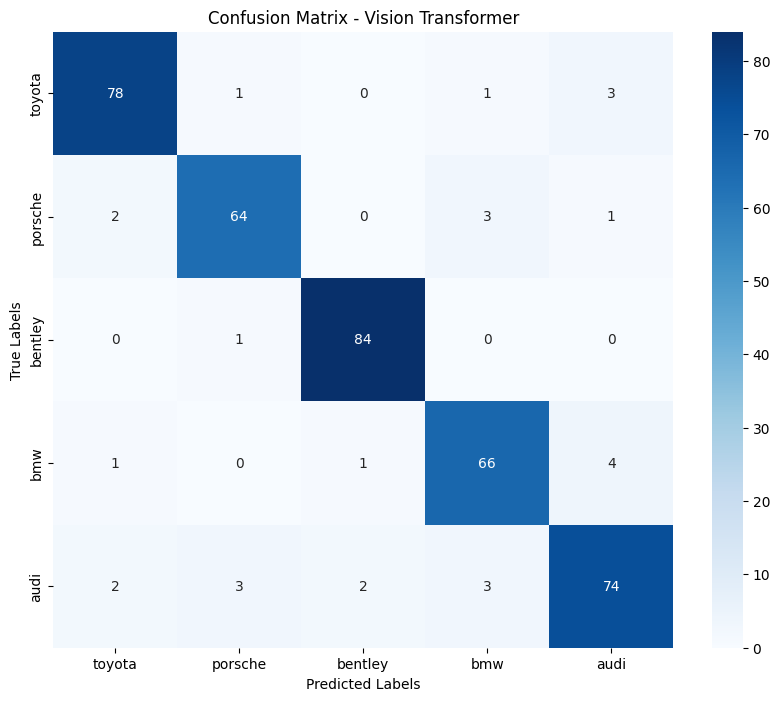

In [46]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CONFIG['classes'],
            yticklabels=CONFIG['classes'])
plt.title('Confusion Matrix - Vision Transformer')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## Визуализация обучения

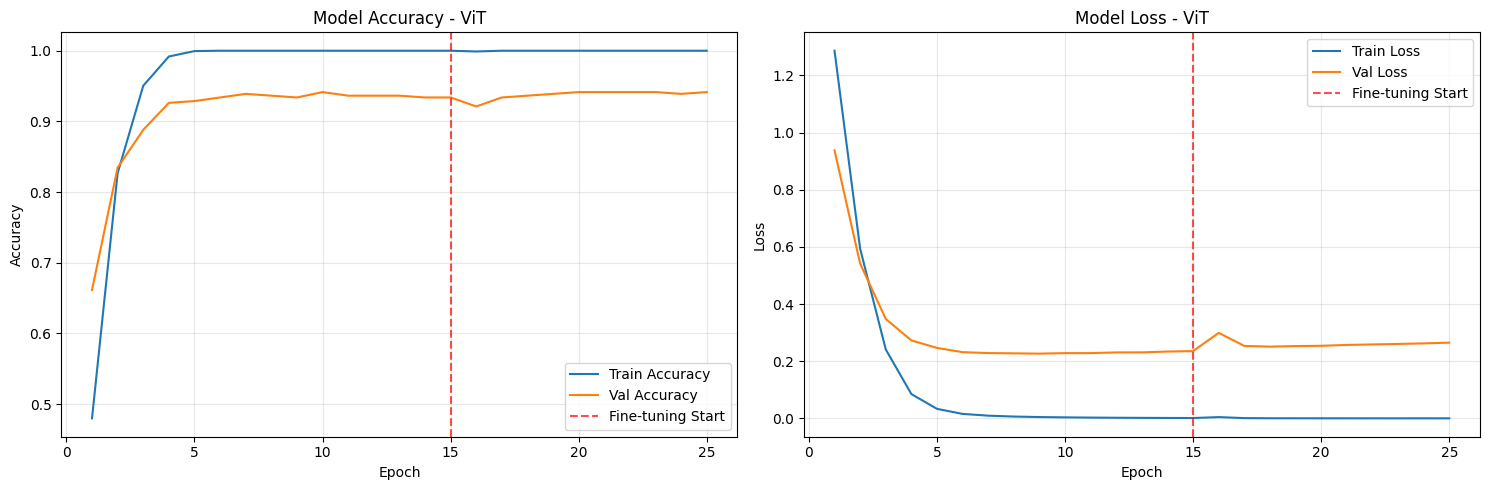

In [47]:
def plot_training_history(history):
    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(15, 5))

    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs_range, history['val_acc'], label='Val Accuracy')
    plt.axvline(x=15, color='r', linestyle='--', alpha=0.7, label='Fine-tuning Start')
    plt.title('Model Accuracy - ViT')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Val Loss')
    plt.axvline(x=15, color='r', linestyle='--', alpha=0.7, label='Fine-tuning Start')
    plt.title('Model Loss - ViT')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Сохранение модели на Google Drive

In [50]:
import os

save_path = r'/content/drive/MyDrive/ML project/best_vit_car_model.pth'
save_dir = os.path.dirname(save_path)

# Создаем директорию, если она не существует
os.makedirs(save_dir, exist_ok=True)

torch.save(vit_model.state_dict(), save_path)
print("Модель сохранена на Google Drive!")

Модель сохранена на Google Drive!


## Функция для предсказания

In [51]:
def predict_car_brand(image_path, model, feature_extractor, device):
    """Функция для предсказания марки автомобиля по изображению"""

    # Загрузка и обработка изображения
    image = Image.open(image_path).convert('RGB')
    encoding = feature_extractor(image, return_tensors='pt')
    pixel_values = encoding['pixel_values'].to(device)

    # Предсказание
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)[0]
        predicted_class = torch.argmax(probabilities).item()
        confidence = probabilities[predicted_class].item()

    class_names = CONFIG['classes']

    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Predicted: {class_names[predicted_class]}\nConfidence: {confidence:.2%}")
    plt.axis('off')

    # График вероятностей
    plt.subplot(1, 2, 2)
    probs = probabilities.cpu().numpy()
    colors = ['green' if i == predicted_class else 'gray' for i in range(len(class_names))]
    plt.barh(class_names, probs, color=colors)
    plt.xlabel('Probability')
    plt.title('Class Probabilities')
    plt.xlim(0, 1)

    plt.tight_layout()
    plt.show()

    return class_names[predicted_class], confidence

## Сравнение с ResNet50

In [52]:
print("\n=== СРАВНЕНИЕ МОДЕЛЕЙ ===\n")

comparison_data = {
    'Metric': ['Test Accuracy', 'Test F1-Score', 'Training Time (min)', 'Model Size (MB)'],
    'ResNet50': [' 0.8579', '0.8551', '46.26', '~90'],
    'Vision Transformer': [f'{test_accuracy:.4f}', f'{test_f1:.4f}',
                          f'{training_time/60:.1f}',
                          f'{os.path.getsize("best_vit_model_stage1.pth")/1024/1024:.1f}']
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n=== МОДЕЛЬ ГОТОВА К ИСПОЛЬЗОВАНИЮ ===")


=== СРАВНЕНИЕ МОДЕЛЕЙ ===

             Metric ResNet50 Vision Transformer
      Test Accuracy   0.8579             0.9289
      Test F1-Score   0.8551             0.9287
Training Time (min)    46.26               35.1
    Model Size (MB)      ~90              327.4

=== МОДЕЛЬ ГОТОВА К ИСПОЛЬЗОВАНИЮ ===


## Измерение времени инференса

In [53]:
def measure_inference_time(model, dataloader, device, num_batches=10):
    """Измеряет среднее время инференса"""
    model.eval()
    times = []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_batches:
                break

            pixel_values = batch['pixel_values'].to(device)

            start = time.time()
            outputs = model(pixel_values=pixel_values)
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            end = time.time()

            times.append(end - start)

    avg_time = np.mean(times)
    avg_per_image = avg_time / CONFIG['batch_size']

    print(f"\nВремя инференса:")
    print(f"Среднее время на batch ({CONFIG['batch_size']} изображений): {avg_time*1000:.2f} ms")
    print(f"Среднее время на одно изображение: {avg_per_image*1000:.2f} ms")

    return avg_time, avg_per_image

inference_time, per_image_time = measure_inference_time(vit_model, test_loader, device)


Время инференса:
Среднее время на batch (32 изображений): 313.90 ms
Среднее время на одно изображение: 9.81 ms
